# Training an ANN with fewer synops
As described in [Sorbaro et al. 2020](https://www.frontiersin.org/articles/10.3389/fnins.2020.00662/full), it can be beneficial for power consumption and latency in the network to reduce the number of synaptic operations (synops). This number is essentially the output activation multiplied by the number of outward connections (fan-out) to the next layer. We describe how using Sinabs' synops counters it's possible to easily add a term to your loss function which then can be minimised.

Let's start by defining our ANN and the training dataset. Keep in mind that we use NeuromorphicRelus here as we need to discretize the output in the forward pass to simulate the number of spikes that layer would emit. In the backward pass the derivative of the ReLU function is used. 

In [1]:
import torch
import torch.nn as nn
import sinabs
import sinabs.layers as sl


ann = nn.Sequential(
    nn.Conv2d(1, 16, 5, bias=False),
    sl.NeuromorphicReLU(),
    sl.SumPool2d(2),
    nn.Conv2d(16, 32, 5, bias=False),
    sl.NeuromorphicReLU(),
    sl.SumPool2d(2),
    nn.Conv2d(32, 120, 4, bias=False),
    sl.NeuromorphicReLU(),
    nn.Flatten(),
    nn.Linear(120, 10, bias=False),
)

In [2]:
from torch.utils.data import DataLoader
import torch
from torchvision import datasets, transforms

to_tensor = transforms.ToTensor()
mnist_train = datasets.MNIST("../tutorials/data", train=True, transform=lambda x: to_tensor(x)*255)
train_loader = DataLoader(mnist_train, batch_size=512, shuffle=True, num_workers=4)

Let's apply a SynopsCounter to our ANN to track how many synaptic operations it would need in an SNN, given a single sample.

In [3]:
synops_counter_ann = sinabs.SynOpCounter(ann.modules(), sum_activations=True)

ann(mnist_train[0][0].unsqueeze(0))
print(f"Synops after feeding input: {synops_counter_ann()}")

Synops after feeding input: 197927.0


We can define a target number of synops and add a term to our objective function to minimise the difference between target synops and actual synops. We're going to add this to our prediction loss for a synops target of 250k.

In [4]:
from tqdm import tqdm

optim = torch.optim.Adam(ann.parameters(), lr=1e-3)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Fix the target number of operations
target_synops = torch.tensor(250_000., device=device)
ann = ann.to(device)
model_losses = []
synops_losses = []
for epoch in tqdm(range(2)):
    for data, target in iter(train_loader):
        data, target = data.to(device), target.to(device)
        output = ann(data)
        optim.zero_grad()

        model_loss = nn.functional.cross_entropy(output, target) 
        synops_loss = nn.functional.mse_loss(synops_counter_ann(), target_synops) / 1e7
        loss = model_loss + synops_loss
        loss.backward()
        optim.step()
        model_losses.append(model_loss.item())
        synops_losses.append(synops_loss.item())

100%|██████████| 2/2 [00:04<00:00,  2.05s/it]


Let's plot the results of both loss terms, one for the prediction and one for the synops. 

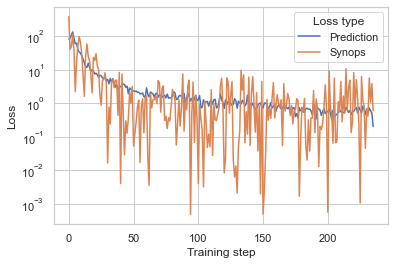

In [13]:
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")

df = pd.DataFrame({
    'Loss type': ['Prediction'] * len(model_losses) + ['Synops'] * len(synops_losses),
    'Loss' : model_losses + synops_losses,
    'Training step' : list(range(len(model_losses))) + list(range(len(synops_losses)))
})
fig = sns.lineplot(df,  x='Training step', y='Loss', hue='Loss type')
fig.set_yscale("log");

Now let's check how we're doing in terms of prediction accuracy on the test set.

In [6]:
mnist_test = datasets.MNIST("../tutorials/data", train=False, transform=lambda x: to_tensor(x)*255)
test_loader = DataLoader(mnist_test, batch_size=512, num_workers=4)

In [7]:
from torchmetrics.classification import MulticlassAccuracy
metric = MulticlassAccuracy(num_classes=10, average='micro').to(device)

accuracies = []
for data, targets in iter(test_loader):
    data, targets = data.to(device), targets.to(device)
    with torch.no_grad():
        output = ann(data)
    metric.update(output.argmax(1), targets)
metric.compute().item()

0.9194999933242798

The prediction accuracy is not exactly state-of-the-art, but we have also optimised for a certain number of outputs, let's check those:

In [8]:
synops_counter_ann().item()

235800.5625

This is not too far from the original target of 250k.